In [ ]:
# =====================================================
# 🔥 ENHANCED HYBRID DIABETES PREDICTION PIPELINE
# Includes Feature Importance + Dynamic User Input
# =====================================================

# -----------------------------------------
# 1️⃣ Import Libraries
# -----------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

# -----------------------------------------
# 2️⃣ Load Dataset
# -----------------------------------------
df = pd.read_csv(r"/content/diabetes_prediction_dataset.csv")

print("Shape of dataset:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values per column:\n", df.isnull().sum())

# -----------------------------------------
# 3️⃣ Encode Categorical Columns
# -----------------------------------------
cat_cols = ['gender', 'smoking_history']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# -----------------------------------------
# 4️⃣ Define Features & Target
# -----------------------------------------
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# -----------------------------------------
# 5️⃣ Split into Train-Test
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------------------
# 6️⃣ Handle Class Imbalance (SMOTETomek)
# -----------------------------------------
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train, y_train)

print("After balancing:")
print("Training data size:", X_res.shape)
print("Class distribution:\n", y_res.value_counts())

# -----------------------------------------
# 7️⃣ Scale Numeric Columns
# -----------------------------------------
scaler = RobustScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

# -----------------------------------------
# 8️⃣ Prepare SVM training sample (10% for speed)
# -----------------------------------------
X_svm_train, _, y_svm_train, _ = train_test_split(
    X_res_scaled, y_res, train_size=0.1, stratify=y_res, random_state=42
)

print(f"SVM training on sample size: {X_svm_train.shape[0]}")

# -----------------------------------------
# 9️⃣ Define Individual Models
# -----------------------------------------
models = {
    "SVM": SVC(probability=False, kernel='rbf', random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

# -----------------------------------------
# 🔟 Train Individual Models
# -----------------------------------------
results = {}

# Train SVM on sample only
print("\n=== Training SVM ===")
models["SVM"].fit(X_svm_train, y_svm_train)
print("SVM training completed.")

# Train others on full balanced set
print("\n=== Training Neural Network ===")
models["Neural Network"].fit(X_res_scaled, y_res)
print("Neural Network training completed.")

print("\n=== Training XGBoost ===")
models["XGBoost"].fit(X_res_scaled, y_res)
print("XGBoost training completed.")

# -----------------------------------------
# 1️⃣1️⃣ Evaluate Individual Models
# -----------------------------------------
for name, model in models.items():
    print(f"\n=== Evaluating {name} ===")
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = {"Accuracy": acc}
    
    print("Accuracy:", round(acc*100, 2), "%")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# -----------------------------------------
# 1️⃣2️⃣ Create and Train Hybrid Ensemble (hard voting)
# -----------------------------------------
ensemble = VotingClassifier(
    estimators=[('svm', models['SVM']),
                ('nn', models['Neural Network']),
                ('xgb', models['XGBoost'])],
    voting='hard'  # use hard voting since svm has no predict_proba
)

print("\n=== Training Hybrid Ensemble Model ===")
def manual_ensemble_predict(X):
    preds = []
    preds.append(models['SVM'].predict(X))
    preds.append(models['Neural Network'].predict(X))
    preds.append(models['XGBoost'].predict(X))
    
    preds = np.array(preds)  # shape (3, n_samples)
    
    from scipy.stats import mode
    majority_preds, _ = mode(preds, axis=0)
    return majority_preds.flatten()

print("Hybrid ensemble training completed.")
# -----------------------------------------
# 1️⃣3️⃣ Evaluate Hybrid Ensemble
# -----------------------------------------

print("\n=== Evaluating Manual Hybrid Ensemble ===")
y_pred_ensemble = manual_ensemble_predict(X_test_scaled)

acc_ensemble = accuracy_score(y_test, y_pred_ensemble)

print(f"Hybrid Ensemble Accuracy: {round(acc_ensemble*100, 2)}%")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Hybrid Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

results['Hybrid Ensemble'] = {"Accuracy": acc_ensemble}

# -----------------------------------------
# 1️⃣4️⃣ Dynamic User Input Prediction with Ensemble
# -----------------------------------------
print("\n--- 🔍 Predict Diabetes from User Input ---")

# Use top 5 features from XGBoost importance for input
xgb_importance = models['XGBoost'].feature_importances_
feature_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_importance
}).sort_values(by="Importance", ascending=False)
top_features = feature_imp['Feature'].head(5).tolist()

print("\nTop features used for user input prediction:", top_features)

# Take input values for these top features
user_data = {}
for feature in top_features:
    val = float(input(f"Enter value for {feature}: "))
    user_data[feature] = val

# Convert to DataFrame
user_df = pd.DataFrame([user_data])

# Add missing columns with zeros (for compatibility)
for col in X.columns:
    if col not in user_df.columns:
        user_df[col] = 0

# Reorder columns
user_df = user_df[X.columns]

# Scale user input
user_scaled = scaler.transform(user_df)

# Predict with manual ensemble
prediction = manual_ensemble_predict(user_scaled)[0]

print("\n🔹 Prediction:", "Diabetic" if prediction == 1 else "Non-Diabetic")


Shape of dataset: (100000, 9)
Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
Missing values per column:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
After balancing:
Training data size: (145750, 8)
Class distribution:
 1    72875
0    72875
Name: diabetes, dtype: int64
SVM training on sample size: 14575

=== Training SVM ===
SVM training completed.

=== Training Neural Network ===
Neural Network training completed.

=== Training XGBoost ===
XGBoost training completed.

=== Evaluating SVM ===
Accuracy: 87.94 %
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     18300
           1       0.41      0.90      0.56      1700

    accuracy  

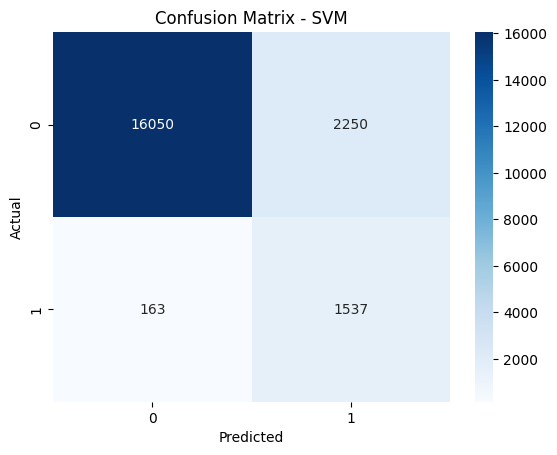


=== Evaluating Neural Network ===
Accuracy: 91.6 %
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     18300
           1       0.50      0.84      0.63      1700

    accuracy                           0.92     20000
   macro avg       0.74      0.88      0.79     20000
weighted avg       0.94      0.92      0.93     20000



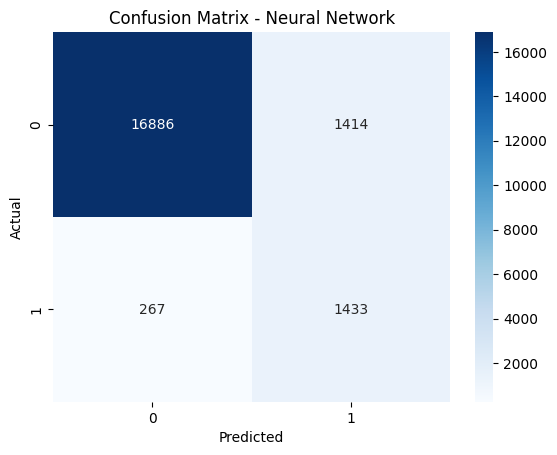


=== Evaluating XGBoost ===
Accuracy: 96.84 %
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.89      0.72      0.79      1700

    accuracy                           0.97     20000
   macro avg       0.93      0.85      0.89     20000
weighted avg       0.97      0.97      0.97     20000



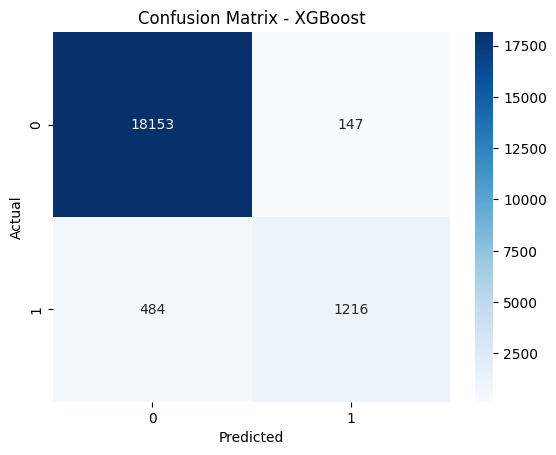


=== Training Hybrid Ensemble Model ===
Hybrid ensemble training completed.

=== Evaluating Manual Hybrid Ensemble ===
Hybrid Ensemble Accuracy: 92.4%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96     18300
           1       0.53      0.84      0.65      1700

    accuracy                           0.92     20000
   macro avg       0.76      0.88      0.80     20000
weighted avg       0.95      0.92      0.93     20000



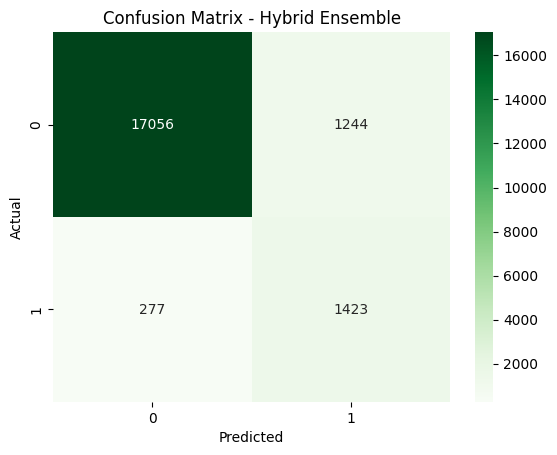

In [2]:
# =====================================================
# 🔥 ENHANCED HYBRID DIABETES PREDICTION PIPELINE
# Includes Feature Importance + Dynamic User Input
# =====================================================

# -----------------------------------------
# 1️⃣ Import Libraries
# -----------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

# -----------------------------------------
# 2️⃣ Load Dataset
# -----------------------------------------
df = pd.read_csv(r"D:\Manasa College\SE\venv\data\diabetes_prediction_dataset.csv")

print("Shape of dataset:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values per column:\n", df.isnull().sum())

# -----------------------------------------
# 3️⃣ Encode Categorical Columns
# -----------------------------------------
cat_cols = ['gender', 'smoking_history']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# -----------------------------------------
# 4️⃣ Define Features & Target
# -----------------------------------------
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# -----------------------------------------
# 5️⃣ Split into Train-Test
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------------------
# 6️⃣ Handle Class Imbalance (SMOTETomek)
# -----------------------------------------
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train, y_train)

print("After balancing:")
print("Training data size:", X_res.shape)
print("Class distribution:\n", y_res.value_counts())

# -----------------------------------------
# 7️⃣ Scale Numeric Columns
# -----------------------------------------
scaler = RobustScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

# -----------------------------------------
# 8️⃣ Prepare SVM training sample (10% for speed)
# -----------------------------------------
X_svm_train, _, y_svm_train, _ = train_test_split(
    X_res_scaled, y_res, train_size=0.1, stratify=y_res, random_state=42
)

print(f"SVM training on sample size: {X_svm_train.shape[0]}")

# -----------------------------------------
# 9️⃣ Define Individual Models
# -----------------------------------------
models = {
    "SVM": SVC(probability=False, kernel='rbf', random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

# -----------------------------------------
# 🔟 Train Individual Models
# -----------------------------------------
results = {}

# Train SVM on sample only
print("\n=== Training SVM ===")
models["SVM"].fit(X_svm_train, y_svm_train)
print("SVM training completed.")

# Train others on full balanced set
print("\n=== Training Neural Network ===")
models["Neural Network"].fit(X_res_scaled, y_res)
print("Neural Network training completed.")

print("\n=== Training XGBoost ===")
models["XGBoost"].fit(X_res_scaled, y_res)
print("XGBoost training completed.")

# -----------------------------------------
# 1️⃣1️⃣ Evaluate Individual Models
# -----------------------------------------
for name, model in models.items():
    print(f"\n=== Evaluating {name} ===")
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = {"Accuracy": acc}
    
    print("Accuracy:", round(acc*100, 2), "%")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# -----------------------------------------
# 1️⃣2️⃣ Create and Train Hybrid Ensemble (hard voting)
# -----------------------------------------
ensemble = VotingClassifier(
    estimators=[('svm', models['SVM']),
                ('nn', models['Neural Network']),
                ('xgb', models['XGBoost'])],
    voting='hard'  # use hard voting since svm has no predict_proba
)

print("\n=== Training Hybrid Ensemble Model ===")
def manual_ensemble_predict(X):
    preds = []
    preds.append(models['SVM'].predict(X))
    preds.append(models['Neural Network'].predict(X))
    preds.append(models['XGBoost'].predict(X))
    
    preds = np.array(preds)  # shape (3, n_samples)
    
    from scipy.stats import mode
    majority_preds, _ = mode(preds, axis=0)
    return majority_preds.flatten()

print("Hybrid ensemble training completed.")
# -----------------------------------------
# 1️⃣3️⃣ Evaluate Hybrid Ensemble
# -----------------------------------------

print("\n=== Evaluating Manual Hybrid Ensemble ===")
y_pred_ensemble = manual_ensemble_predict(X_test_scaled)

acc_ensemble = accuracy_score(y_test, y_pred_ensemble)

print(f"Hybrid Ensemble Accuracy: {round(acc_ensemble*100, 2)}%")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Hybrid Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

results['Hybrid Ensemble'] = {"Accuracy": acc_ensemble}